In [8]:
#league rules!
numberOfTeams = 10

isFlex = True

ppr = 1
rushYards = .1
receivingYards = .1
rushTD = 6
receivingTD = 6
passYards = 1/25
passTD = 4
fmb = -2
int = -2

In [9]:
import pandas as pd, numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from scipy.stats import norm
from joblib import dump

In [10]:
combo2 = pd.read_csv("2023_model_data.csv")
modelData = combo2.drop(columns=["Name", "Unnamed: 0", "team.y", "position.y", "position.x", "team.x", "nextSeasonsTeam", "gsis_id", "team", "name rank", "gsis_id", "team.y", "position.y"])

In [11]:
#label encoding
label_encoders = {}
for column in modelData.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    modelData[column] = le.fit_transform(modelData[column])
    label_encoders[column] = le

In [104]:
season = 2023
train = modelData[modelData["year"] < season]
test = modelData[modelData["year"] == season]
c2_whole = combo2[combo2["year"] == season]
names = c2_whole['Name'].reset_index(drop=True)
positions = c2_whole['position'].reset_index(drop=True)

In [105]:
#data
train_y = train["nextSeasonPAR"]
train_x = train.drop(columns = "nextSeasonPAR", axis = 1)
test_y = test["nextSeasonPAR"]
test_x = test.drop(columns = "nextSeasonPAR", axis = 1)

In [106]:
#train it
ntrees = 500
rf = RandomForestRegressor(n_estimators=ntrees)
rf.fit(train_x, train_y)

RandomForestRegressor(n_estimators=500)

In [103]:
#FOR SAVING MODEL FOR CALIBRATION
# dump(rf, f"models/{season}_rf_{ntrees}tree.joblib")
# test_x.to_csv(f"data/test_x_{season}.csv", index=False)
# test_y.to_csv(f"data/test_y_{season}.csv", index=False)
# c2_whole.to_csv(f"data/c2_whole_{season}.csv", index=False)

In [109]:
#residuals plot
preds = rf.predict(test_x)

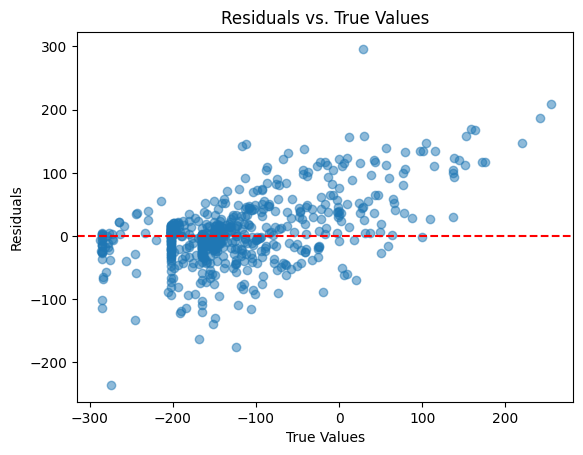

In [80]:
residuals = test_y - preds

# Plot residuals
plt.scatter(test_y, residuals, alpha=0.5)
plt.title('Residuals vs. True Values')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [81]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(test_y, preds)
mse = mean_squared_error(test_y, preds)
r2 = r2_score(test_y, rf.predict(test_x))

print(f"MAE: {mae}, MSE: {mse}, R^2: {r2}")

MAE: 36.12028068322981, MSE: 2891.335805279812, R^2: 0.6703781558399704


In [110]:
#prediction distributions
# Get predictions from each tree in the RandomForestRegressor
tree_predictions = []

for tree in rf.estimators_:
    tree_predictions.append(tree.predict(test_x))

# Convert the predictions to a DataFrame
tree_predictions_df = pd.DataFrame(tree_predictions).transpose()
tree_predictions_df.columns = [f"Tree_{i+1}" for i in range(rf.n_estimators)]

# Display the first few rows of the tree predictions DataFrame
tree_predictions_df.head()

/Users/jacksoslow/Documents/Projects/fantasy-football/.venv/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jacksoslow/Documents/Projects/fantasy-football/.venv/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jacksoslow/Documents/Projects/fantasy-football/.venv/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jacksoslow/Documents/Projects/fantasy-football/.venv/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jacksoslow/Documents/Projects/fantasy-football/.venv/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X 

,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10,...,Tree_491,Tree_492,Tree_493,Tree_494,Tree_495,Tree_496,Tree_497,Tree_498,Tree_499,Tree_500
0,-102.90,19.40,21.30,24.00,99.60,10.10,125.72,136.70,185.32,29.96,...,18.70,102.00,39.52,10.10,-60.20,-13.40,144.18,32.52,-74.10,72.0
1,-6.64,57.22,57.22,-194.30,125.72,57.04,-8.90,0.00,103.46,62.98,...,-245.58,-145.06,-27.64,-21.28,-21.28,163.68,103.46,57.22,144.18,20.5
2,62.98,59.70,-6.64,27.22,65.34,32.60,45.46,70.00,-164.34,-245.58,...,-245.58,-157.66,-21.28,115.24,3.56,-145.06,29.90,27.22,144.18,102.0
3,-155.00,62.80,-161.90,62.80,220.40,137.50,69.90,-155.00,-161.90,-155.00,...,-161.90,242.70,89.82,-155.00,-155.00,-74.10,295.20,212.10,227.80,220.2
4,45.46,97.62,125.34,-245.58,3.56,0.00,171.26,70.14,-147.60,-145.06,...,102.00,3.56,97.62,0.00,-164.34,163.68,103.46,30.30,-98.92,38.8


In [111]:
#include more details in pred dataframe
tree_predictions_df['name'] = names
tree_predictions_df['preds'] = preds
tree_predictions_df['pos'] = positions

tree_predictions_df

,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10,...,Tree_494,Tree_495,Tree_496,Tree_497,Tree_498,Tree_499,Tree_500,name,preds,pos
0,-102.90,19.40,21.30,24.00,99.60,10.10,125.72,136.70,185.32,29.96,...,10.10,-60.20,-13.40,144.18,32.52,-74.10,72.00,PatrickMahomes,27.80060,QB
1,-6.64,57.22,57.22,-194.30,125.72,57.04,-8.90,0.00,103.46,62.98,...,-21.28,-21.28,163.68,103.46,57.22,144.18,20.50,JalenHurts,36.37244,QB
2,62.98,59.70,-6.64,27.22,65.34,32.60,45.46,70.00,-164.34,-245.58,...,115.24,3.56,-145.06,29.90,27.22,144.18,102.00,JoshAllen,16.86512,QB
3,-155.00,62.80,-161.90,62.80,220.40,137.50,69.90,-155.00,-161.90,-155.00,...,-155.00,-155.00,-74.10,295.20,212.10,227.80,220.20,ChristianMcCaffrey,89.09264,RB
4,45.46,97.62,125.34,-245.58,3.56,0.00,171.26,70.14,-147.60,-145.06,...,0.00,-164.34,163.68,103.46,30.30,-98.92,38.80,JoeBurrow,35.12412,QB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,-165.40,-160.80,-165.40,-168.30,-168.30,-169.90,-168.30,-131.40,-168.30,-168.30,...,-168.30,-168.30,-168.30,-168.30,-168.30,-167.40,-165.50,JakeTonges,-158.61748,TE
607,-193.50,-124.26,-193.50,-202.40,-124.26,-193.50,-140.80,-202.40,-194.00,-202.40,...,-124.26,-198.20,-199.90,-202.40,-202.40,-199.90,-124.26,JoshAli,-183.58212,WR
608,-276.44,-273.44,-275.90,-257.60,-265.24,-276.50,-262.00,-272.78,-266.64,-253.48,...,-274.74,-275.90,-272.78,-253.48,-287.74,-257.60,-194.38,NateSudfeld,-263.26508,QB
609,-247.58,-274.74,-274.74,-257.60,-213.62,-275.70,-284.86,-274.74,-264.84,-257.60,...,-266.00,-275.54,-272.78,-272.02,-275.70,-269.68,-275.90,CJBeathard,-269.32448,QB


In [112]:
#add posrank
# Group by position, sort by RF_Prediction in descending order, then assign a rank within each group
tree_predictions_df['posrank'] = np.int64(tree_predictions_df.groupby('pos')['preds'].rank(ascending=False, method='min'))

# Sort the DataFrame based on position and then by Positional_Rank
tree_predictions_df = tree_predictions_df.sort_values(by=['pos', 'posrank'])

tree_predictions_df

,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10,...,Tree_495,Tree_496,Tree_497,Tree_498,Tree_499,Tree_500,name,preds,pos,posrank
1,-6.64,57.22,57.22,-194.30,125.72,57.04,-8.90,0.00,103.46,62.98,...,-21.28,163.68,103.46,57.22,144.18,20.5,JalenHurts,36.37244,QB,1
4,45.46,97.62,125.34,-245.58,3.56,0.00,171.26,70.14,-147.60,-145.06,...,-164.34,163.68,103.46,30.30,-98.92,38.8,JoeBurrow,35.12412,QB,2
0,-102.90,19.40,21.30,24.00,99.60,10.10,125.72,136.70,185.32,29.96,...,-60.20,-13.40,144.18,32.52,-74.10,72.0,PatrickMahomes,27.80060,QB,3
28,-118.60,105.90,-69.34,-113.90,-280.70,77.34,-33.48,-0.94,36.00,23.94,...,-40.50,171.26,6.92,163.68,-6.64,-0.4,JustinFields,22.15460,QB,4
2,62.98,59.70,-6.64,27.22,65.34,32.60,45.46,70.00,-164.34,-245.58,...,3.56,-145.06,29.90,27.22,144.18,102.0,JoshAllen,16.86512,QB,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,-202.40,-220.14,-202.40,-220.14,-220.14,-201.40,-140.80,-202.40,-202.40,-220.14,...,-200.20,-221.36,-209.64,-202.40,-202.40,-202.4,JohnMetchie,-202.79984,WR,232
576,-220.14,-220.14,-202.40,-216.42,-220.14,-200.20,-216.42,-202.40,-216.42,-220.14,...,-200.20,-216.42,-209.64,-220.14,-202.40,-200.2,JonathanMingo,-203.47632,WR,233
573,-220.14,-220.14,-202.40,-216.42,-220.14,-200.20,-216.42,-202.40,-216.42,-220.14,...,-200.20,-216.42,-209.64,-220.14,-202.40,-200.2,ZayFlowers,-205.11408,WR,234
583,-202.40,-220.14,-202.40,-216.42,-220.14,-201.40,-140.80,-202.40,-202.40,-220.14,...,-200.20,-221.36,-209.64,-202.40,-202.40,-202.4,MarvinMims,-205.22236,WR,235


In [113]:
#make the "individuals" df
individuals = tree_predictions_df.copy()
tree_predictions_df[tree_predictions_df['posrank'] <= 3]

,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10,...,Tree_495,Tree_496,Tree_497,Tree_498,Tree_499,Tree_500,name,preds,pos,posrank
1,-6.64,57.22,57.22,-194.30,125.72,57.04,-8.90,0.00,103.46,62.98,...,-21.28,163.68,103.46,57.22,144.18,20.50,JalenHurts,36.37244,QB,1
4,45.46,97.62,125.34,-245.58,3.56,0.00,171.26,70.14,-147.60,-145.06,...,-164.34,163.68,103.46,30.30,-98.92,38.80,JoeBurrow,35.12412,QB,2
0,-102.90,19.40,21.30,24.00,99.60,10.10,125.72,136.70,185.32,29.96,...,-60.20,-13.40,144.18,32.52,-74.10,72.00,PatrickMahomes,27.80060,QB,3
6,64.10,239.86,203.30,251.70,89.82,137.50,58.46,260.30,9.00,111.50,...,-155.00,-161.90,47.00,111.50,176.20,205.40,AustinEkeler,118.45396,RB,1
3,-155.00,62.80,-161.90,62.80,220.40,137.50,69.90,-155.00,-161.90,-155.00,...,-155.00,-74.10,295.20,212.10,227.80,220.20,ChristianMcCaffrey,89.09264,RB,2
19,111.50,83.10,162.70,117.54,89.82,-51.00,41.20,89.20,137.36,254.46,...,67.10,150.80,-64.60,174.30,199.20,50.50,DerrickHenry,72.47996,RB,3
5,-161.90,-162.00,166.38,2.50,-119.84,-162.00,203.30,89.30,220.20,-119.16,...,130.10,-119.16,166.38,5.50,149.66,241.40,TravisKelce,58.16672,TE,1
33,33.60,28.66,28.00,-117.50,91.60,-1.30,125.20,163.20,77.10,67.50,...,84.20,121.96,82.70,171.40,54.00,41.64,TJHockenson,16.65528,TE,2
86,30.40,-21.80,15.30,60.00,-121.40,60.00,-37.70,87.10,-14.00,-152.10,...,336.86,124.70,30.80,41.60,-75.42,28.26,DallasGoedert,16.49468,TE,3
9,50.30,76.18,38.80,131.20,136.70,164.00,100.96,-119.84,-127.54,-199.10,...,76.18,90.72,26.30,163.20,239.86,-0.24,CeeDeeLamb,115.17160,WR,1


In [114]:
#make a pred copy df
preds_copy = test_x.reset_index(drop=True).copy()
preds_copy['name'] = names
preds_copy['pos'] = positions
preds_copy['preds'] = preds
preds_copy['adp'] = preds_copy['rank'] * 1.2
preds_copy['adp_sd'] = preds_copy['rank'] * .5 + 1


preds_copy = preds_copy[['name', 'pos', 'rank', 'PAR', 'preds', 'adp', 'adp_sd']]

preds_copy.sort_values(by = 'rank')

,name,pos,rank,PAR,preds,adp,adp_sd
7,JustinJefferson,WR,1,175.08,107.13204,1.2,1.5
6,AustinEkeler,RB,2,217.30,118.45396,2.4,2.0
20,JaMarrChase,WR,3,99.94,62.57144,3.6,2.5
3,ChristianMcCaffrey,RB,4,251.56,89.09264,4.8,3.0
5,TravisKelce,TE,5,241.40,58.16672,6.0,3.5
...,...,...,...,...,...,...,...
333,ZachGentry,TE,300,-117.10,-142.22900,360.0,151.0
332,DyamiBrown,WR,300,-169.60,-159.34324,360.0,151.0
331,BrevinJordan,TE,300,-116.50,-130.36508,360.0,151.0
329,JalenNailor,WR,300,-169.50,-170.86688,360.0,151.0


In [115]:
individuals.to_csv("data/individuals.csv", index=False) 
preds_copy.to_csv("data/preds_copy.csv", index=False)

In [116]:
#get replacement level player by position
import pandas as pd

# Filtering data based on conditions
replacement_rb = individuals[(individuals['pos'] == 'RB') & (individuals['posrank'] == 26)].iloc[:, :ntrees]
replacement_wr = individuals[(individuals['pos'] == 'WR') & (individuals['posrank'] == 26)].iloc[:, :ntrees]
replacement_te = individuals[(individuals['pos'] == 'TE') & (individuals['posrank'] == 11)].iloc[:, :ntrees]
replacement_qb = individuals[(individuals['pos'] == 'QB') & (individuals['posrank'] == 11)].iloc[:, :ntrees]

In [117]:
#roundup function
def roundUp(x, to=numberOfTeams):
    return to * (x // to + (x % to > 0))

In [118]:
def draft_optimize(individuals = individuals, yourTeam = yourTeam, draftedOverall = draftedOverall, preds_copy = preds_copy):
    # Assuming necessary data is already loaded: individuals, preds_copy, draftedOverall, yourTeam, etc.
    # ... [Your data loading code here]

    # Initialize DataFrames and lists
    createdDataframe = pd.DataFrame()
    secondDataframe = pd.DataFrame()
    created_rows = []

    yourDraft = individuals[individuals['name'].isin(yourTeam)]
    yourDraft['teamrank'] = np.int64(yourDraft.groupby('pos')['preds'].rank(ascending=False, method='min'))

    first_rb = yourDraft[(yourDraft['teamrank'] == 1) & (yourDraft['pos'] == 'RB')]
    second_rb = yourDraft[(yourDraft['teamrank'] == 2) & (yourDraft['pos'] == 'RB')]
    third_rb = yourDraft[(yourDraft['teamrank'] == 3) & (yourDraft['pos'] == 'RB')]
    first_wr = yourDraft[(yourDraft['teamrank'] == 1) & (yourDraft['pos'] == 'WR')]
    second_wr = yourDraft[(yourDraft['teamrank'] == 2) & (yourDraft['pos'] == 'WR')]
    third_wr = yourDraft[(yourDraft['teamrank'] == 3) & (yourDraft['pos'] == 'WR')]
    first_te = yourDraft[(yourDraft['teamrank'] == 1) & (yourDraft['pos'] == 'TE')]
    first_qb = yourDraft[(yourDraft['teamrank'] == 1) & (yourDraft['pos'] == 'QB')]

    first_flex = third_rb if third_rb.preds.max() > third_wr.preds.max() else third_wr

    # For RBs
    t_rb = replacement_rb.transpose()
    rbs = pd.concat([t_rb.sample(frac=1).transpose() for _ in range(3)], axis=0)
    if not first_rb.empty:
        rbs.iloc[0, :] = first_rb.iloc[0, :ntrees]
    if not second_rb.empty:
        rbs.iloc[1, :] = second_rb.iloc[0, :ntrees]
    if not first_flex.empty:
        rbs.iloc[2, :] = first_flex.iloc[0, :ntrees]

    # For WRs
    t_wr = replacement_wr.transpose()
    wrs = pd.concat([t_wr.sample(frac=1).transpose() for _ in range(3)], axis=0)
    if not first_wr.empty:
        wrs.iloc[0, :] = first_wr.iloc[0, :ntrees]
    if not second_wr.empty:
        wrs.iloc[1, :] = second_wr.iloc[0, :ntrees]
    if not first_flex.empty:
        wrs.iloc[2, :] = first_flex.iloc[0, :ntrees]

    # For TEs
    tes = replacement_te.copy()  # Create a copy to prevent modification of original dataframe
    if not first_te.empty:
        tes.iloc[0, :] = first_te.iloc[0, :ntrees]

    # For QBs
    qbs = replacement_qb.copy()  # Create a copy to prevent modification of original dataframe
    if not first_qb.empty:
        qbs.iloc[0, :] = first_qb.iloc[0, :ntrees]

    # Dictionary for positions
    pos_dict = {
        'RB': rbs,
        'WR': wrs,
        'TE': tes,
        'QB': qbs
    }

    # Filter out players in draftedOverall from copy
    available = preds_copy[~preds_copy['name'].isin(draftedOverall)]
    available = available.sort_values(by=['pos', 'preds'], ascending=False).groupby('pos').head(25).reset_index(drop=True)

    for j in range(len(available)):
        player = available.iloc[j]
        name = player['name']
        position = player['pos']

        # Use dictionary to get positional_df
        positional_df = pos_dict[position]

        indi_preds = individuals[(individuals['name'] == name) & (individuals['pos'] == position)].iloc[:, :ntrees].iloc[0]
        total_pt_gains = 0
        pct_better = 0

        for i in range(len(positional_df)):
            row = positional_df.iloc[i]
            better = indi_preds.values > row[::-1].values  # Using values to get numpy arrays
            pct_better = max(pct_better, sum(better) / ntrees)
            avg_pts_gains = np.mean(indi_preds[better].values - np.array(row[::-1])[better])
            total_pt_gains = max(total_pt_gains, pct_better * avg_pts_gains)

        # Finding pick number, your next pick, and the likelihood of a player staying on board
        pickNumber = len(draftedOverall) + 1
        ceiling = roundUp(pickNumber, numberOfTeams)
        leftTillEndOfRound = ceiling - pickNumber
        nextPick = ceiling + leftTillEndOfRound + 1

        # Calculating the chance of staying on board
        chanceOfStayingOnBoard = round(1 - norm.cdf(nextPick, player['adp'], player['adp_sd']), 2)

        # For the round after the likelihood
        ceiling = roundUp(nextPick, numberOfTeams)
        leftTillEndOfRound = ceiling - nextPick
        pickAfter = ceiling + leftTillEndOfRound + 1

        chanceOfStayingOnBoardTwoRounds = 1 - norm.cdf(pickAfter, player['adp'], player['adp_sd'])

        # For the round after...
        ceiling = roundUp(pickAfter, numberOfTeams)
        leftTillEndOfRound = ceiling - pickAfter
        pickEvenAfter = ceiling + leftTillEndOfRound + 1

        chanceOfStayingOnThreeRounds = 1 - norm.cdf(pickEvenAfter, player['adp'], player['adp_sd'])

        # Creating a dictionary to represent the new row
        created_row = {
            'name': player['name'],
            'pos': position,
            'preds': player['preds'],
            'pct_better': pct_better,
            'ADP': player['adp'],
            'total_pt_gains': total_pt_gains,
            'chanceOfStayingOnBoard': chanceOfStayingOnBoard,
            'chanceOfStayingOnBoardTwoRounds': chanceOfStayingOnBoardTwoRounds,
            'chanceOfStayingOnThreeRounds': chanceOfStayingOnThreeRounds
        }
        created_rows.append(created_row)

    # Convert the created rows to a DataFrame
    createdDataframe = pd.DataFrame(created_rows)

    # Process for the second dataframe
    second_rows = []

    for _, newRow in createdDataframe.iterrows():
        playerPosition = newRow['pos']

        # Filter and sort
        positionallyFiltered = createdDataframe[createdDataframe['pos'] == playerPosition]
        positionallyFiltered = positionallyFiltered.sort_values(by='total_pt_gains', ascending=False).head(12).copy()

        # Initialize new columns
        positionallyFiltered['chance_of_best_option'] = 0
        positionallyFiltered['chance_of_best_option_2'] = 0
        positionallyFiltered['chance_of_best_option_3'] = 0

        for j, row in positionallyFiltered.iterrows():
            better_players = positionallyFiltered[positionallyFiltered['total_pt_gains'] > row['total_pt_gains']]

            # Calculating probabilities for best option next round
            p_noone_better = np.prod(1 - better_players['chanceOfStayingOnBoard'])
            p_avail = row['chanceOfStayingOnBoard']
            p_best_option = p_noone_better * p_avail
            positionallyFiltered.at[j, 'chance_of_best_option'] = p_best_option

            # ... for two rounds later
            p_noone_better = np.prod(1 - better_players['chanceOfStayingOnBoardTwoRounds'])
            p_avail = row['chanceOfStayingOnBoardTwoRounds']
            p_best_option = p_noone_better * p_avail
            positionallyFiltered.at[j, 'chance_of_best_option_2'] = p_best_option

            # ... and for three rounds later
            p_noone_better = np.prod(1 - better_players['chanceOfStayingOnThreeRounds'])
            p_avail = row['chanceOfStayingOnThreeRounds']
            p_best_option = p_noone_better * p_avail
            positionallyFiltered.at[j, 'chance_of_best_option_3'] = p_best_option

        # Calculating average positional values
        nextRoundValue = np.sum(positionallyFiltered['chance_of_best_option'] * positionallyFiltered['total_pt_gains'])
        nextRoundValue = 1000 if np.isinf(nextRoundValue) or np.isnan(nextRoundValue) else nextRoundValue
        newRow['valueOverNextRound'] = newRow['total_pt_gains'] - nextRoundValue

        valueOverTwoRounds = np.sum(positionallyFiltered['chance_of_best_option_2'] * positionallyFiltered['total_pt_gains'])
        valueOverTwoRounds = 1000 if np.isinf(valueOverTwoRounds) or np.isnan(valueOverTwoRounds) else valueOverTwoRounds
        newRow['valueOverTwoRounds'] = newRow['total_pt_gains'] - valueOverTwoRounds

        valueOverThreeRounds = np.sum(positionallyFiltered['chance_of_best_option_3'] * positionallyFiltered['total_pt_gains'])
        valueOverThreeRounds = 1000 if np.isinf(valueOverThreeRounds) or np.isnan(valueOverThreeRounds) else valueOverThreeRounds
        newRow['valueOverThreeRounds'] = newRow['total_pt_gains'] - valueOverThreeRounds

        second_rows.append(newRow)

    secondDataframe = pd.DataFrame(second_rows)

    print(nextPick)
    return secondDataframe

In [119]:
#your team
draftedOverall = []

yourTeam = []

In [120]:
secondDataframe = draft_optimize(draftedOverall=draftedOverall, yourTeam=yourTeam)

desired_columns = ['name', 'pos', 'valueOverNextRound', 'ADP', 'chanceOfStayingOnBoard', 'preds']
secondDataframe = pd.concat([secondDataframe[desired_columns], secondDataframe.drop(desired_columns, axis=1)], axis=1)

secondDataframe.sort_values(by = 'valueOverNextRound', ascending = False)

20


,name,pos,valueOverNextRound,ADP,chanceOfStayingOnBoard,preds,pct_better,total_pt_gains,chanceOfStayingOnBoardTwoRounds,chanceOfStayingOnThreeRounds,valueOverTwoRounds,valueOverThreeRounds
50,AustinEkeler,RB,59.890225,2.4,0.00,118.45396,0.808,159.30308,0.000000e+00,0.000000,61.242247,84.502919
25,TravisKelce,TE,46.200124,6.0,0.00,58.16672,0.724,120.92108,9.107649e-06,0.000000,46.212070,46.473421
51,ChristianMcCaffrey,RB,38.923225,4.8,0.00,89.09264,0.748,138.33608,3.332045e-08,0.000000,40.275247,63.535919
0,CeeDeeLamb,WR,28.597385,16.8,0.34,115.17160,0.892,135.04084,2.997916e-01,0.001866,31.224187,77.157298
1,JustinJefferson,WR,27.773025,1.2,0.00,107.13204,0.826,134.21648,0.000000e+00,0.000000,30.399827,76.332938
...,...,...,...,...,...,...,...,...,...,...,...,...
96,KylerMurray,QB,-67.118736,207.6,0.98,-111.31700,0.300,31.55880,9.835201e-01,0.972281,-67.097356,-65.571841
97,JimmyGaroppolo,QB,-67.157936,264.0,0.99,-122.37324,0.286,31.51960,9.857085e-01,0.978205,-67.136556,-65.611041
94,DerekCarr,QB,-68.830496,262.8,0.99,-103.92732,0.306,29.84704,9.856738e-01,0.978115,-68.809116,-67.283601
98,JordanLove,QB,-71.658936,294.0,0.99,-131.09276,0.256,27.01860,9.864657e-01,0.980141,-71.637556,-70.112041


In [121]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(secondDataframe.sort_values(by = 'preds', ascending = False))

,name,pos,valueOverNextRound,ADP,chanceOfStayingOnBoard,preds,pct_better,total_pt_gains,chanceOfStayingOnBoardTwoRounds,chanceOfStayingOnThreeRounds,valueOverTwoRounds,valueOverThreeRounds
50,AustinEkeler,RB,59.890225,2.4,0.00,118.45396,0.808,159.30308,0.000000e+00,0.000000e+00,61.242247,84.502919
0,CeeDeeLamb,WR,28.597385,16.8,0.34,115.17160,0.892,135.04084,2.997916e-01,1.865813e-03,31.224187,77.157298
1,JustinJefferson,WR,27.773025,1.2,0.00,107.13204,0.826,134.21648,0.000000e+00,0.000000e+00,30.399827,76.332938
51,ChristianMcCaffrey,RB,38.923225,4.8,0.00,89.09264,0.748,138.33608,3.332045e-08,0.000000e+00,40.275247,63.535919
52,DerrickHenry,RB,19.417585,12.0,0.09,72.47996,0.734,118.83044,6.680720e-02,1.530627e-06,20.769607,44.030279
2,DavanteAdams,WR,-7.584495,13.2,0.15,66.31196,0.760,98.85896,1.150697e-01,1.869224e-05,-4.957693,40.975418
3,AJBrown,WR,-9.323295,20.4,0.52,65.99976,0.736,97.12016,4.748204e-01,1.954881e-02,-6.696493,39.236618
4,JaMarrChase,WR,-4.817415,3.6,0.00,62.57144,0.714,101.62604,1.701417e-12,0.000000e+00,-2.190613,43.742498
5,CooperKupp,WR,-12.639055,7.2,0.00,60.06296,0.738,93.80440,2.802933e-04,1.110223e-16,-10.012253,35.920858
25,TravisKelce,TE,46.200124,6.0,0.00,58.16672,0.724,120.92108,9.107649e-06,0.000000e+00,46.212070,46.473421


In [34]:
draft_optimize()

,name,pos,preds,pct_better,ADP,total_pt_gains,chanceOfStayingOnBoard,chanceOfStayingOnBoardTwoRounds,chanceOfStayingOnThreeRounds,valueOverNextRound,valueOverTwoRounds,valueOverThreeRounds
0,JustinJefferson,WR,119.5592,0.87,1.2,143.7710,0.00,0.000000e+00,0.000000,36.680057,39.488931,109.542010
1,CeeDeeLamb,WR,111.4798,0.89,16.8,133.9694,0.34,2.997916e-01,0.001866,26.878457,29.687331,99.740410
2,AJBrown,WR,71.9400,0.80,20.4,101.3710,0.52,4.748204e-01,0.019549,-5.719943,-2.911069,67.142010
3,JaMarrChase,WR,66.3996,0.72,3.6,102.5502,0.00,1.701417e-12,0.000000,-4.540743,-1.731869,68.321210
4,DavanteAdams,WR,59.6212,0.77,13.2,97.3902,0.15,1.150697e-01,0.000019,-9.700743,-6.891869,63.161210
...,...,...,...,...,...,...,...,...,...,...,...,...
95,KylerMurray,QB,-113.8756,0.27,207.6,36.8894,0.98,9.835201e-01,0.972281,-70.297311,-70.266574,-69.129216
96,AnthonyRichardson,QB,-118.1908,0.30,140.4,25.4994,0.98,9.776104e-01,0.954236,-81.687311,-81.656574,-80.519216
97,CJStroud,QB,-124.5558,0.26,320.4,24.7070,0.99,9.869937e-01,0.981454,-82.479711,-82.448974,-81.311616
98,JordanLove,QB,-136.0058,0.26,294.0,25.5974,0.99,9.864657e-01,0.980141,-81.589311,-81.558574,-80.421216


In [131]:
print(yourDraft['preds'].isnull().sum())


0


In [132]:
print(pd.__version__)


2.0.3


In [137]:
yourDraft.groupby('pos')['preds'].rank(ascending=False, method='min').apply(lambda x: np.int64(x).item())

9    1
Name: preds, dtype: int64

In [138]:
yourDraft

,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10,...,Tree_96,Tree_97,Tree_98,Tree_99,Tree_100,name,preds,pos,posrank,ranked_preds
9,41.2,120.0,67.1,125.0,58.8,-141.2,62.8,7.6,295.2,62.8,...,106.06,251.7,137.5,24.0,150.8,JonathanTaylor,73.8214,RB,4,1
